# Problem 1 #

In [63]:
import numpy as np
from stoppingpower.cmsp import S_c
from stoppingpower.range import rangeout
from stoppingpower.range import nuclear_fraction
from stoppingpower.range import exit_energy
from stoppingpower.range import energy_deposition
from stoppingpower.materials import materials
import pandas as pd
import scipy.constants as const

In [51]:
t = rangeout(1.0, materials['Water'], 150., 1.0)
t

15.875464708225147

In [52]:
water_thickness = np.arange(0., t, 2.)

In [53]:
water_thickness = np.append(water_thickness, np.arange(water_thickness[-1]+0.2, t-0.4, 0.2))

In [54]:
water_thickness = np.append(water_thickness, np.arange(water_thickness[-1]+0.1, t, 0.1))
water_thickness = np.append(water_thickness, t)
water_thickness

array([  0.        ,   2.        ,   4.        ,   6.        ,
         8.        ,  10.        ,  12.        ,  14.        ,
        14.2       ,  14.4       ,  14.6       ,  14.8       ,
        15.        ,  15.2       ,  15.4       ,  15.5       ,
        15.6       ,  15.7       ,  15.8       ,  15.87546471])

In [55]:
T0 = 150. # MeV

In [56]:
T1 = exit_energy(1., materials["Air"], T0, 1., 1.)

In [57]:
E_IC1 = energy_deposition(1., materials["Air"], T0, 1., 1.)

In [65]:
energy_per_ion_pair = 35.2 # for proton in air, Anderson table 11.1
diameter = 10. # cm
charge_per_proton = const.value('elementary charge') # 1.602e-19 C
flux = 10**5 # protons per cm^2 per s

def current(T_deposited_per_proton, flux, diameter):
    radius = diameter / 2.
    area = np.pi * radius ** 2
    
    ion_pairs_per_proton = T_deposited_per_proton / energy_per_ion_pair
    
    protons_per_second = flux * diameter
    
    current = ion_pairs_per_proton * protons_per_second * charge_per_proton
    
    return current

I_IC1 = current(E_IC1, flux, diameter)

4.36361735121795e-17

In [58]:
T2 = [exit_energy(1., materials["Water"], T1, 1., t) for t in water_thickness]

In [59]:
T3 = [exit_energy(1., materials["Air"], T, 1., 1.) for T in T2]

In [67]:
E_IC2 = np.array([energy_deposition(1., materials["Air"], T, 1., 1.) for T in T2])

In [68]:
I_IC2 = current(E_IC2, flux, diameter)

array([  4.36391837e-17,   4.60362697e-17,   4.90097157e-17,
         5.28367131e-17,   5.80172612e-17,   6.56131144e-17,
         7.83725539e-17,   1.07517558e-16,   1.13001777e-16,
         1.19537050e-16,   1.27468729e-16,   1.37502208e-16,
         1.50698104e-16,   1.69087729e-16,   1.97800082e-16,
         2.19816467e-16,   2.52427241e-16,   3.07803024e-16,
         4.44752392e-16,   0.00000000e+00])

In [81]:
table1 = pd.DataFrame(
    {
        "Beam energy after exit from IC1": T1,
        "Energy deposited in IC1": E_IC1,
        "Current in IC1": I_IC1,
        "Beam energy after exit from water column": T2,
        "Beam energy after exit from IC2": T3,
        "Energy deposited in IC2": E_IC2, 
        "Current in IC2": I_IC2
    },
    index=water_thickness
)
cols = table.columns.tolist()
cols = [
    'Beam energy after exit from IC1',
    'Energy deposited in IC1',
    'Current in IC1',
    'Beam energy after exit from water column',
    'Beam energy after exit from IC2',
    'Energy deposited in IC2',
    'Current in IC2'
]
table1 = table[cols]
table1

,Beam energy after exit from IC1,Energy deposited in IC1,Current in IC1,Beam energy after exit from water column,Beam energy after exit from IC2,Energy deposited in IC2,Current in IC2
0.000000,149.990413,0.009587,4.363617e-17,149.984995,149.975407,0.009588,4.363918e-17
2.000000,149.990413,0.009587,4.363617e-17,138.881885,138.871771,0.010114,4.603627e-17
4.000000,149.990413,0.009587,4.363617e-17,127.115816,127.105049,0.010767,4.900972e-17
6.000000,149.990413,0.009587,4.363617e-17,114.505824,114.494216,0.011608,5.283671e-17
8.000000,149.990413,0.009587,4.363617e-17,100.796824,100.784078,0.012746,5.801726e-17
10.000000,149.990413,0.009587,4.363617e-17,85.523835,85.509420,0.014415,6.561311e-17
12.000000,149.990413,0.009587,4.363617e-17,67.820278,67.803059,0.017219,7.837255e-17
14.000000,149.990413,0.009587,4.363617e-17,45.376491,45.352869,0.023622,1.075176e-16
14.200000,149.990413,0.009587,4.363617e-17,42.633767,42.608940,0.024827,1.130018e-16
14.400000,149.990413,0.009587,4.363617e-17,39.741686,39.715423,0.026262,1.195370e-16


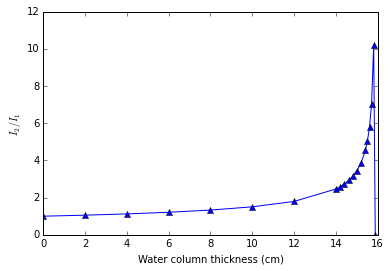

In [84]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(water_thickness, table['Current in IC2'] / table['Current in IC1'], 'b-^')
plt.ylabel(r'${I_2}/{I_1}$')
plt.xlabel('Water column thickness (cm)')
plt.savefig('ne551_midterm_1_1c', dpi=300)
plt.show()

In [82]:
table2 = pd.DataFrame(index=water_thickness)

In [87]:
table2['Beam energy after exit from IC1'] = table1['Beam energy after exit from IC1']
table2['Energy deposited in IC1'] = table1['Energy deposited in IC1']
table2['Current in IC1'] = table1['Current in IC1']
table2['Beam energy after exit from water column'] = table['Beam energy after exit from water column']
table2['Fraction of beam remaining after exit from water column'] =\
        1-nuclear_fraction(1., materials['Water'], water_thickness)
table2['Beam energy after exit from IC2'] = table1['Beam energy after exit from IC2']
table2['Energy deposited in IC2'] = table1['Energy deposited in IC2']
table2['Current in IC2'] = current(
    table2['Energy deposited in IC2'],
    flux*table2['Fraction of beam remaining after exit from water column'],
    diameter
)
table2

,Beam energy after exit from IC1,Energy deposited in IC1,Current in IC1,Beam energy after exit from water column,Fraction of beam remaining after exit from water column,Beam energy after exit from IC2,Energy deposited in IC2,Current in IC2
0.000000,149.990413,0.009587,4.363617e-17,149.984995,1.000000,149.975407,0.009588,4.363918e-17
2.000000,149.990413,0.009587,4.363617e-17,138.881885,0.919622,138.871771,0.010114,4.233599e-17
4.000000,149.990413,0.009587,4.363617e-17,127.115816,0.845705,127.105049,0.010767,4.144778e-17
6.000000,149.990413,0.009587,4.363617e-17,114.505824,0.777730,114.494216,0.011608,4.109268e-17
8.000000,149.990413,0.009587,4.363617e-17,100.796824,0.715218,100.784078,0.012746,4.149498e-17
10.000000,149.990413,0.009587,4.363617e-17,85.523835,0.657730,85.509420,0.014415,4.315573e-17
12.000000,149.990413,0.009587,4.363617e-17,67.820278,0.604864,67.803059,0.017219,4.740470e-17
14.000000,149.990413,0.009587,4.363617e-17,45.376491,0.556246,45.352869,0.023622,5.980623e-17
14.200000,149.990413,0.009587,4.363617e-17,42.633767,0.551605,42.608940,0.024827,6.233231e-17
14.400000,149.990413,0.009587,4.363617e-17,39.741686,0.547002,39.715423,0.026262,6.538700e-17


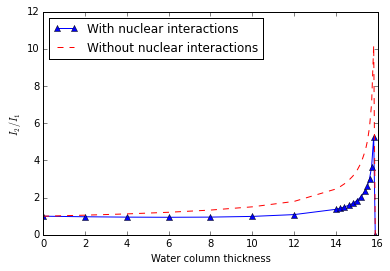

In [93]:
plt.plot(water_thickness, table2['Current in IC2'] / table2['Current in IC1'], 'b-^', label='With nuclear interactions')
plt.plot(water_thickness, table1['Current in IC2'] / table1['Current in IC1'], 'r--', label='Without nuclear interactions')
plt.xlabel('Water column thickness')
plt.ylabel(r'$I_2 / I_1$')
plt.legend(loc=2)
plt.savefig('ne551_midterm_1_1g', dpi=300)
plt.show()

# Problem 2 #

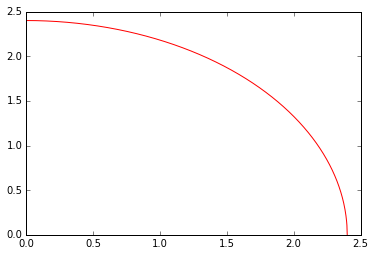

In [108]:
r = 2.4
x = np.linspace(0, r, 1000)
plt.plot(x, np.sqrt(r**2 - x**2), 'r-')
plt.show()

# Problem 3 #

In [110]:
N_A = const.Avogadro
print N_A
r_0 = const.value('classical electron radius') * 100. # convert to cm
print "Classical electron radius: {0} cm".format(r_0)
m_e = const.value('electron mass energy equivalent in MeV')
print "Electron mass: {0}".format(m_e)
Z = 74.
A = 184.
T = np.array([1., 10., 20., 50., 100., 200., 500., 1000., 2000.]) / 1000. # convert to MeV

6.022140857e+23
2.8179403227e-13
0.5109989461


In [111]:
from stoppingpower.utility import beta_2

In [ ]:
def F_+(T):
    b = beta_2(m=m_e, T=T)    
    tau = T / m_e
    
    return np.log(2.) - b / 24. 8 (23. + 14/(tau + 2.) + 10/(tau + 2.)**2 + 4/(tau + 2.)**3)

def F_-(T):
    b = beta_2(m=m_e, T=T)
    tau = T / m_e
    
    return 0.5 * (1 - b) * (1 + tau**2 / 8 - (2 * tau + 1) * np.log(2.))

def electron_stopping_power(T):
    first = 2 * np.pi * r_0**2 * m_e * N_A
    second = Z / (A)
    third = 